In [1]:
from WatAnalysis.utils import guess_surface_indices
from ase import io
from MDAnalysis import Universe

data_file = "tests/data/task_000000/system.data"
traj_file = "tests/data/task_000000/trajectory.xtc" # lammps.dump.gz" 

atoms = io.read(data_file, format='lammps-data')
surf1, surf2 = guess_surface_indices(atoms)

# Load the universe
universe = Universe(
    data_file,
    traj_file,
    topology_format='DATA',
    format="XTC",
    atom_style="id type x y z",
    dt=0.005,
)

universe.trajectory

<XTCReader tests/data/task_000000/trajectory.xtc with 200001 frames of 669 atoms>

In [2]:
# from WatAnalysis.utils import identify_water_molecules

# ## Add bond information
# universe.add_TopologyAttr('resname')

# charges = []
# bonds = []

# wall = universe.select_atoms('type 3')
# water = universe.atoms - wall

# # Residue for wall
# for i, atom in enumerate(wall):
#     res = universe.add_Residue(
#         resid=i,
#         resname='WALL',
#         resnum=i,
#     )
#     atom.residue = res
#     charges.append(0.0)

# water_dict = identify_water_molecules(
#     water.select_atoms('type 1').positions,
#     water.select_atoms('type 2').positions,
#     universe.dimensions,
#     oh_cutoff=1.3,
#     ignore_warnings=True,
# )

# h_indices = water.select_atoms('type 1').indices
# o_indices = water.select_atoms('type 2').indices

# # Residue and bonds for water
# i = 0
# for o_idx, h_list in water_dict.items():
#     res = universe.add_Residue(
#         resid=len(wall)+i,
#         resname='SOL',
#         resnum=len(wall)+i,
#     )

#     universe.atoms[o_indices[o_idx]].residue = res

#     for h_idx in h_list:
#         bonds.append([o_indices[o_idx], h_indices[h_idx]])
#         universe.atoms[h_indices[h_idx]].residue = res
    
#     i += 1

# universe.add_bonds(bonds)
# universe._topology.bonds

In [3]:
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis

hba_default = HydrogenBondAnalysis(
    universe,
    donors_sel="type 2",
    acceptors_sel="type 2",
    hydrogens_sel="type 1",
    d_a_cutoff=3.5,
    d_h_cutoff=1.2,
    d_h_a_angle_cutoff=120,
)
hba_default.run(start=0, stop=20000, verbose=True)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [4]:
hba_default.results.hbonds.shape  # frame (0), donor (1), hydrogen (2), acceptor (3), distance (4), angle (5)

(5725832, 6)

In [5]:
atoms = io.read(data_file, format='lammps-data')

from ase.visualize import view 
hbonds = hba_default.results.hbonds.astype(int)
frame_num = 243
view(
    atoms[
        [
            hbonds[frame_num, 1], 
            hbonds[frame_num, 2], 
            hbonds[frame_num, 2] + 1, 
            hbonds[frame_num, 3], 
            hbonds[frame_num, 3] + 1, 
            hbonds[frame_num, 3] + 2
        ]+ surf1 + surf2
    ], 
    viewer='x3d'
)

In [6]:
import numpy as np
np.unique(hbonds[:, 3]).shape

(151,)

In [9]:
from WatAnalysis.analysis import WaterAnalysis

wa = WaterAnalysis(
    universe=universe,
    surf_ids=[surf1, surf2],
    oxygen_sel="type 2",
    hydrogen_sel="type 1",
)
wa.run(start=0, stop=20000, verbose=True)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [10]:
import numpy as np 
o_indices = universe.select_atoms('type 2').indices

frames = hba_default.results.hbonds[:, 0].astype(int)
d_ids = hba_default.results.hbonds[:, 1].astype(int)
a_ids = hba_default.results.hbonds[:, 3].astype(int)

d_z_coords = wa.results.z_water[frames, np.searchsorted(o_indices, d_ids)]
a_z_coords = wa.results.z_water[frames, np.searchsorted(o_indices, a_ids)]

z1 = wa.results.z1.mean().item()
z2 = wa.results.z2.mean().item()
zmax = (z2 + z1) / 2
dz = 0.05

# d_z_coords[d_z_coords > zmax] = z2 - d_z_coords[d_z_coords > zmax] 
# a_z_coords[a_z_coords > zmax] = z2 - a_z_coords[a_z_coords > zmax]

H, xedges, yedges = np.histogram2d(
    x=d_z_coords, 
    y=a_z_coords, 
    bins=int(zmax/dz), 
    range=[[z1, zmax], [z1, zmax]],
    # density=True
)
H = H.T  # Transpose for visualization because histogram does not follow Cartesion convention!!!

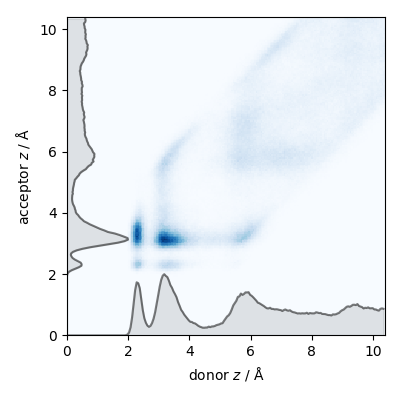

In [13]:
from matplotlib import pyplot as plt 
from WatAnalysis.utils import bin_edges_to_grid
from WatAnalysis.waterstructure import calc_density_profile

%matplotlib widget
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_aspect('equal')

# Plot donor/acceptor matrix
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H, cmap='Blues')

# z, rho = wa.density_profile(sym=True, dz=dz)
# # normfac = 
# ax.plot(z[z<zmax], rho[z<zmax], color='tab:red', alpha=0.5)
# ax.plot(rho[z<zmax], z[z<zmax], color='tab:red', alpha=0.5)

## Donor density profile
z, rho = calc_density_profile(
    z_surf=[z1, z2],
    z_water=d_z_coords,
    cross_area=wa.results.cross_area,
    n_frames=wa.n_frames * 2,
    dz=dz,
)
rho /= rho.max() 
rho *= 2

ax.plot(z[z<zmax], rho[z<zmax], color='k', alpha=0.5)
ax.fill_between(z[z<zmax], y1=np.zeros(rho[z<zmax].shape), y2=rho[z<zmax], color='k', alpha=0.1)

## Acceptor density profile
z, rho = calc_density_profile(
    z_surf=[z1, z2],
    z_water=a_z_coords,
    cross_area=wa.results.cross_area,
    n_frames=wa.n_frames * 2,
    dz=dz,
)
rho /= rho.max() 
rho *= 2

ax.plot(rho[z<zmax], z[z<zmax], color='k', alpha=0.5)
ax.fill_betweenx(z[z<zmax], x1=np.zeros(rho[z<zmax].shape), x2=rho[z<zmax], color='k', alpha=0.1)

ax.set_xlabel(r"donor $z$ / $\mathrm{\AA}$")
ax.set_ylabel(r"acceptor $z$ / $\mathrm{\AA}$")
fig.tight_layout()